# In depth skewed data classif.
https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

이 노트북은 편향된 데이터에 대해 여러 테스트를 합니다. 해당 아이디어는 예측 모델의 효율성을 저해할 수 있는 어떤 압도적인 주 클래스가 있을 때 어떤 전처리가 더 잘 작동하는지를 비교합니다.

각기 다른 모델에 하이퍼파라미터 튜닝에 대한 교차 검증도 살펴 봅니다. 다음과 같은 모델을 사용합니다:
1. Logistic Regression
2. SVM
3. Decision Trees

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Loading the dataset

In [31]:
data = pd.read_csv('./input/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Checking the target classes

Text(0, 0.5, 'Frequency')

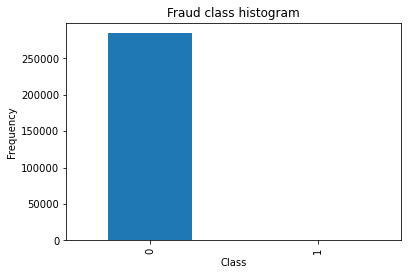

In [32]:
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()
count_classes.plot(kind='bar')
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

데이터가 엄청나게 불균형임을 알 수 있습니다.

이것은 일반적인 정확도 점수를 사용하여 분류 알고리즘을 평가하는 명확한 예입니다.

예를 들어, 만약 모든 데이터에 대해 주 클래스를 사용하여 값을 할당한다면, 높은 점수를 얻을 수는 있겠지만 모든 분류를 "1"로 잘못 분류할 수 있습니다.

이러한 불균형을 고려하는 분류 문제에 대해 몇 가지 접근을 해볼 수 있습니다.
- 데이터를 더 수집하는 것 -> 좋은 전략이나 이번 케이스에는 적합하지 않습니다.
- 성능 지표를 바꾸는것:
    - 혼동 매트릭스를 사용하여 Precision과 Recall을 계산
    - F1score(precision recall에 대한 가중 평균)
    - Kappa - 데이터의 불균형을 정규화한 분류 정확도
    - ROC 커브 - sensitivity/specificity ratio 계산
- 데이터셋 리샘플링
    - 데이터를 약 50대50의 비율로 맞추는 방법
    - 데이터를 적게 가지고 있을 때, 적은 수의 클래스 데이터를 복제하는 오버샘플링을 통한 방법
    - 데이터를 많이 가지고 있을 때, 많은 수의 클래스 데이터를 삭제하는 언더샘플링을 통한 방법

## Approach
1. 처음부터 피처 엔지니어링을 진행하지 않습니다. 데이터셋은 30개의 피처(28개의 익명변수 + time + amount)
2. 리샘플링을 했을 때와 하지 않았을 때를 비교합니다. 단순 로지스틱 회귀 분류기를 통해 이를 테스트 합니다.
3. 위에서 언급한 몇 가지 평가 지표를 통해 모델을 평가합니다.
4. 로지스틱 회귀 분류기의 파라미터를 조정하면서 가장 좋았던 리샘플링을 하거나/하지 않은 케이스를 반복합니다.
5. 마지막으로 다른 분류 알고리즘을 사용하여 분류를 수행합니다.

## Setting out input and target variables + resampling

### 1. amount열에 대해 정규화를 진행합니다. 

In [33]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))
data = data.drop(['Time', 'Amount'], axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### 2. 리샘플링
- 처음 언급했던 것처럼, 편향된 데이터를 리샘플링하는 여러 방법이 있습니다. 언더/오버샘플링을 떠나서, 매우 인기있는 접근인 오버/언더샘플링을 조합하지만 오버샘플링을 소수 클래스를 복제하는 것이 아닌 알고리즘을 통해 새로운 소수 클래스 데이터 인스턴스를 구성하는 SMOTE(Synthetic Minority Over-Sampling Technique)가 있습니다.
- 이 노트북에서는 전통적인 언더샘플링을 사용합니다. 
- 데이터셋을 50대50 비율이 될 때 까지 언더샘플링합니다. 이는 주 클래스 샘플의 'x'만큼 선택해 소수 클래스에서 총 레코드 수를 'x'로 지정합니다.

In [34]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [35]:
# 소수 클래스의 데이터 개수
number_records_fraud = len(data[data.Class==1])
fraud_indices = np.array(data[data.Class==1].index)

# 일반 클래스의 인덱스 추출
normal_indices = data[data.Class==0].index

# 추출한 인덱스에서 랜덤하게 'x'개 선택(number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# 2개의 인덱스 결합
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# 언더샘플링 데이터셋
under_sample_data = data.iloc[under_sample_indices, :]

X_undersample = under_sample_data.loc[:, under_sample_data.columns!='Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns=='Class']

# 비율
print('Ratio of normal transactions: ', len(under_sample_data[under_sample_data.Class==0])/len(under_sample_data))
print('Ratio of fraud transactions: ', len(under_sample_data[under_sample_data.Class==1])/len(under_sample_data))
print('Total number of transaction in resampled data: ', len(under_sample_data))

Ratio of normal transactions:  0.5
Ratio of fraud transactions:  0.5
Total number of transaction in resampled data:  984


## Splitting Data and Cross Validation

In [36]:
from sklearn.model_selection import train_test_split

# 전체 데이터셋
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('Number transactions train dataset: ', len(X_train))
print('Number transactions test dataset: ', len(X_test))
print('Total number of transactions: ', len(X_train)+len(X_test))

# 언더샘플링 데이터셋
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=0)

print("")
print('Number transactions train dataset: ', len(X_train_undersample))
print('Number transactions test dataset: ', len(X_test_undersample))
print('Total number of transactions: ', len(X_train_undersample)+len(X_test_undersample))

Number transactions train dataset:  199364
Number transactions test dataset:  85443
Total number of transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


## Logistic regression classifier - Undersampled data

recall score가 가장 부정한 거래를 포착하는 데 도움이 되는 평가지표이기 때문에, 이를 살펴봅니다. Precision과 recall이 혼돈 매트릭스에 어떻게 작용하는지 알고 있는 경우 recall은 매우 흥미로운 지표가 될 수 있습니다.

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

우리가 알고 있듯이, 데이터의 불균형때문에 많은 관측이 FN으로 관측됩니다. 따라서 Recall은 이를 포착합니다.
- 명백하게, recall을 증가시키면 precision이 감소하는 경향이 있습니다. 그러나, 이 케이스에서는 정상 거래를 사기라고 판명하는 경우가 반대인 경우보다 덜 심각한 문제입니다.
- 또한 FN과 FP를 다른 가중치를 갖는 비용함수를 적용할수도 있습니다.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

### Very ad-hoc function to print k_fold_scores

In [62]:
def printing_kfold_scores(x_train_data, y_train_data):
    fold = KFold(5,shuffle=False)
    
    # Different C params
    c_param_range = [0.01, 0.1, 1, 10, 100]
    
    result_table = pd.DataFrame(index=range(len(c_param_range),2), columns=['C_parameter', 'Mean recall score'])
    result_table['C_parameter'] = c_param_range
    
    # k-fold는 2개의 리스트 제공: train_indices=indices[0], test_indices=indices[1]
    j = 0
    for c_param in c_param_range:
        print('-'*30)
        print('C parameter: ', c_param)
        print('-'*30)
        print('')
        
        recall_accs = []
        for iteration, indices in enumerate(fold.split(x_train_data), start=1):
            # 특정 C 파라미터를 가진 로지스틱 회귀 모형 호출
            lr = LogisticRegression(C = c_param, penalty='l2')
            
            # 폴드된 훈련 데이터를 사용하여 모델 훈련
            # 모델을 가지고 예측
            lr.fit(x_train_data.iloc[indices[0],:], y_train_data.iloc[indices[0],:].values.ravel())
            
            # 훈련 데이터의 테스트 인덱스를 사용하여 값 예측
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)
            # recall score 계산 후 현재 C값과 리스트에 추가
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,
                                      y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration, ': recall score = ', recall_acc)
            
        # recall score의 평균 저장
        result_table.loc[j, 'Mean recall score'] = np.mean(recall_acc)
        j += 1
        print('')
        print('Mean recall score', np.mean(recall_accs))
        print('')
        
    best_c = result_table.iloc[result_table['Mean recall score'].astype(float).idxmax()]['C_parameter']
    
    # 최종적으로, 가장 최고의 C 파라미터 확인
    print('*'*30)
    print('Best model to choose from cross validation is with C parameter=', best_c)
    return best_c

In [63]:
best_c = printing_kfold_scores(X_test_undersample, y_train_undersample)

------------------------------
C parameter:  0.01
------------------------------

Iteration  1 : recall score =  0.5294117647058824
Iteration  2 : recall score =  0.4838709677419355
Iteration  3 : recall score =  0.5
Iteration  4 : recall score =  0.48484848484848486
Iteration  5 : recall score =  0.8461538461538461

Mean recall score 0.5688570126900298

------------------------------
C parameter:  0.1
------------------------------

Iteration  1 : recall score =  0.5
Iteration  2 : recall score =  0.3225806451612903
Iteration  3 : recall score =  0.5333333333333333
Iteration  4 : recall score =  0.45454545454545453
Iteration  5 : recall score =  0.8846153846153846

Mean recall score 0.5390149635310926

------------------------------
C parameter:  1
------------------------------

Iteration  1 : recall score =  0.5588235294117647
Iteration  2 : recall score =  0.3548387096774194
Iteration  3 : recall score =  0.5666666666666667
Iteration  4 : recall score =  0.42424242424242425


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

Iteration  5 : recall score =  0.8846153846153846

Mean recall score 0.5578373429227319

------------------------------
C parameter:  10
------------------------------

Iteration  1 : recall score =  0.5294117647058824
Iteration  2 : recall score =  0.3548387096774194
Iteration  3 : recall score =  0.6
Iteration  4 : recall score =  0.48484848484848486
Iteration  5 : recall score =  0.8846153846153846

Mean recall score 0.5707428687694343

------------------------------
C parameter:  100
------------------------------

Iteration  1 : recall score =  0.5
Iteration  2 : recall score =  0.3548387096774194
Iteration  3 : recall score =  0.6
Iteration  4 : recall score =  0.48484848484848486
Iteration  5 : recall score =  0.8846153846153846

Mean recall score 0.5648605158282578

******************************
Best model to choose from cross validation is with C parameter= 0.1


C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\envs\tens_2g\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/line

### Confusion matrix

In [64]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    혼동 매트릭스를 그리는 함수
    정규화는 normalize=True 시 적용
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

예측 모델이 얼마나 효과적인지를 recall score을 사용하는 것에 대해 말해왔습니다. 그렇지만 언더샘플링된 데이터가 특정 클래스에 대한 왜도가 없기 때문에 recall 평가 지표가 매우 중요하지 않음을 기억해두시기 바랍니다. 

Recall metric in the testing dataset:  0.9183673469387755


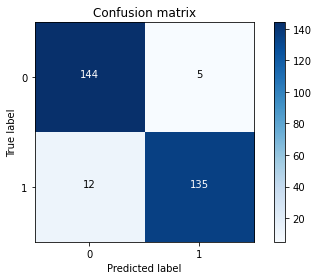

In [65]:
# C_parameter을 사용하여 최종 모델을 구축
lr = LogisticRegression(C=best_c, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# 혼동 매트릭스 계산
cnf_matrix = confusion_matrix(y_test_undersample, y_pred_undersample)
np.set_printoptions(precision=2)

print('Recall metric in the testing dataset: ', cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 정규화되지 않은 혼동 매트릭스 그림
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='Confusion matrix')
plt.show()

언더샘플링 테스트 셋의 recall 점수가 91.8%가 나왔습니다.

얻은 결과가 나쁘지 않네요, 우리 모델을 전체 데이터 셋에 대해 테스트해봅니다.

Recall metric in the testing dataset:  0.9115646258503401


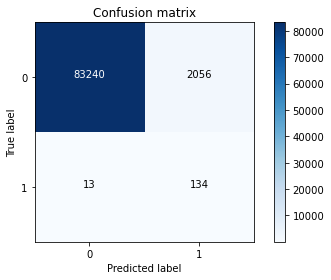

In [69]:
lr = LogisticRegression(C=best_c, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# 혼동 매트릭스 계산
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# 정규화되지 않은 혼동 매트릭스 계산
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='Confusion matrix')
plt.show()

매우 치우친 데이터셋에서도 recall 점수가 높게 나왔습니다.

### Plotting ROC curve Precision-Recall curve
- '양성'클래스를 '음성'클래스보다 중요하게 여기는 이 문제에서는 precision-recall 곡선이 더 편리합니다. (그러나 혼동매트릭스를 그려봤기 때문에 아직 그리지 않겠습니다.)
- AUC 와 ROC 곡선은 또한 모형이 전체적으로 정확하게 예측하고 많은 오차를 만들지는 않는지 확인하는 데 유용합니다.

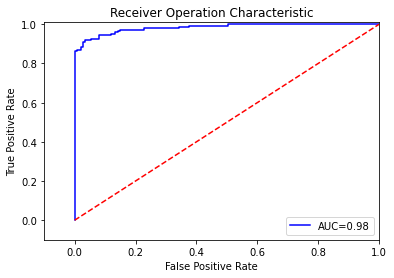

In [70]:
# ROC CURVE
lr = LogisticRegression(C=best_c, penalty='l2')
y_pred_undersample_score = lr.fit(X_train_undersample, y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(), y_pred_undersample_score)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operation Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC=%0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

언더샘플링한 데이터 세트를 여러번 초기화하고 프로세스를 반복하는 것이 흥미로운 결과를 가져올 수 있습니다. 

언더샘플링 데이터를 생성하기 위해 주 클래스에서 랜덤하게 데이터를 얻었습니다. 이는 유효한 테크닉이지만 실제 모집단을 나타내지 않으므로 서로 다른 언더샘플링 구성으로 프로세스를 반복하고 이전에 선택했던 데이터가 여전히 가장 효과적인지 확인하는 것이 좋습니다. 

결국 전체 데이터 세트를 여러번 언더샘플링을 반복하고 평균적인 최상의 파라미터를 선택하는 것이 아이디어입니다.

## Logistic regression classifier - Skewed data

In [71]:
best_c = printing_kfold_scores(X_train, y_train)

------------------------------
C parameter:  0.01
------------------------------

Iteration  1 : recall score =  0.5373134328358209
Iteration  2 : recall score =  0.6164383561643836
Iteration  3 : recall score =  0.6666666666666666
Iteration  4 : recall score =  0.6
Iteration  5 : recall score =  0.5

Mean recall score 0.5840836911333742

------------------------------
C parameter:  0.1
------------------------------

Iteration  1 : recall score =  0.5522388059701493
Iteration  2 : recall score =  0.6164383561643836
Iteration  3 : recall score =  0.7166666666666667
Iteration  4 : recall score =  0.6153846153846154
Iteration  5 : recall score =  0.5625

Mean recall score 0.612645688837163

------------------------------
C parameter:  1
------------------------------

Iteration  1 : recall score =  0.5522388059701493
Iteration  2 : recall score =  0.6164383561643836
Iteration  3 : recall score =  0.7333333333333333
Iteration  4 : recall score =  0.6153846153846154
Iteration  5 : recall s

Recall metric in the testing dataset:  0.6190476190476191


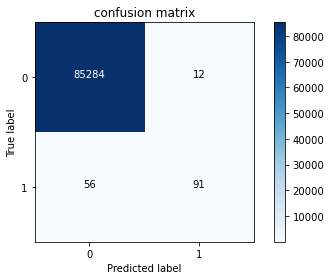

In [73]:
lr = LogisticRegression(C=best_c, penalty='l2')
lr.fit(X_train, y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)

# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='confusion matrix')
plt.show()

## Change Classification Threshold

데이터를 언더샘플링함으로써 알고리즘이 사기를 탐지하는 데 효과적이라는 것을 살펴봤습니다. 또한 임계값을 변경하여 최종 분류를 어떻게 조정할지 살펴보겠습니다.
- 처음에는 분류 모델을 구축하고 관측하지 않은 데이터에 사용합니다.
- 이전에는 `predict()`메서드를 이용하여 '1', '0'을 결정했습니다.
- 이번에는 `predict_proba()`를 사용합니다.
    - 이 메서드는 각 클래스에 대한 확률을 반환합니다. 클래스 1에 대한 임계값을 변경하여 precision 과 recall 값을 조정할 수 있습니다.
   

Recall metric in the testing dataset:  0.9795918367346939
Recall metric in the testing dataset:  0.9455782312925171
Recall metric in the testing dataset:  0.9251700680272109
Recall metric in the testing dataset:  0.9251700680272109
Recall metric in the testing dataset:  0.9183673469387755
Recall metric in the testing dataset:  0.891156462585034
Recall metric in the testing dataset:  0.8639455782312925
Recall metric in the testing dataset:  0.8639455782312925
Recall metric in the testing dataset:  0.8503401360544217


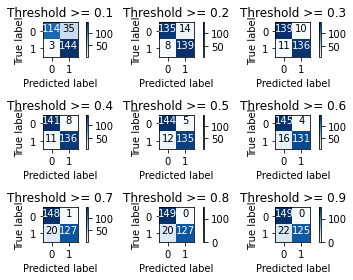

In [74]:
lr = LogisticRegression(C=0.1, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure()

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Confusion matrix
    cnf_matrix = confusion_matrix(y_test_undersample, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    
    print('Recall metric in the testing dataset: ', cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    
    # plot
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix,
                          classes=class_names,
                          title='Threshold >= %s'%i)

클래스 1에 특정 값을 입력하는 데 필요한 확률을 낮출수록 더 많은 기록이 들어갑니다.

이는 recall의 증가를 의미하나, 동시에 정확도의 감소를 의미합니다.

recall이 우리의 목표 평가지표지만, 모델이 정확도를 잃지 않았으면 좋겠습니다.
- 다시 임계값 변경으로 돌아가면 Precision-Recall 곡선이라는 옵션이 있습니다. 선택한 임계값에 따라 모델의 성능을 시각적으로 확인함으로써 높은 정밀도 값을 유지하면서recall이 충분히 높은 지점을 찾을 수 있습니다.

### Precision-Recall curve

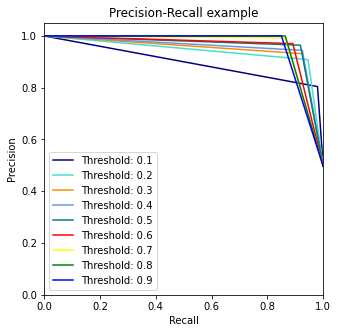

In [76]:
from itertools import cycle
lr = LogisticRegression(C=0.1, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue', 'black'])

plt.figure(figsize=(5,5))

j = 1
for i, color in zip(thresholds, colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_undersample, y_test_predictions_prob)
    
    # plot
    plt.plot(recall, precision, color=color,
             label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc='lower left')

임계값이 0.2일 때 정확도와 리콜이 어느정도 높게 나오므로 이가 적당해보입니다.